In [11]:
%matplotlib inline

In [12]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.io

In [13]:
oxy_data=scipy.io.loadmat('oxy_ts.mat')

In [14]:
oxy_data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Feb 24 11:53:59 2015',
 '__version__': '1.0',
 'names': array([[array(['L Frontal Sup'], 
       dtype='<U13'),
         array(['L Frontal Med Orbital'], 
       dtype='<U21'),
         array(['L Cingulum Post'], 
       dtype='<U15'),
         array(['R Amygdala'], 
       dtype='<U10')]], dtype=object),
 'ts_roi_oxytocin': array([[-3.77557662, -5.77365114, -9.57021654, -0.9384245 ],
        [-3.47519884, -5.38728432, -9.11882644, -0.66167455],
        [-2.91696258, -4.65462627, -8.26556558, -0.12829601],
        ..., 
        [ 1.29530079,  2.13907671,  2.70376582,  6.80861642],
        [ 1.65333978,  2.34770588,  2.78201873,  8.02016985],
        [ 1.8444468 ,  2.4606193 ,  2.81709313,  8.66115912]]),
 'ts_roi_placebo': array([[-6.0988565 , -4.76972472, -4.16927416,  2.33500703],
        [-5.73770686, -4.49071092, -3.82386596,  2.22337126],
        [-5.07860676, -3.97045432, -3.18317154,  2.0

4.15789336424 1.6481695587


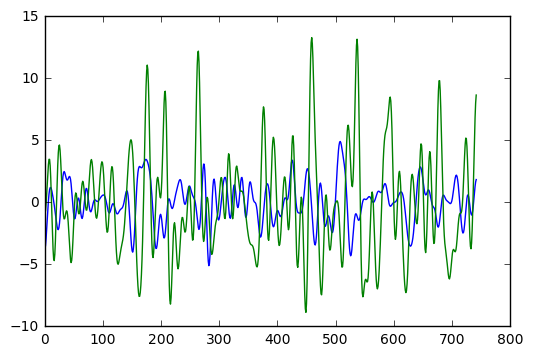

In [15]:
amy_oxy=oxy_data['ts_roi_oxytocin'][:,3]
front_oxy=oxy_data['ts_roi_oxytocin'][:,0]
frontmed_oxy=oxy_data['ts_roi_oxytocin'][:,1]
cing_oxy=oxy_data['ts_roi_oxytocin'][:,2]
print(amy_oxy.std(),front_oxy.std())
plt.figure()
plt.plot(front_oxy)
plt.plot(amy_oxy)

1.94482918031 1.88143549929


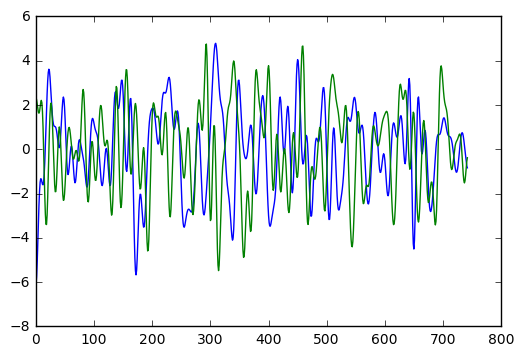

In [16]:
amy_pla=oxy_data['ts_roi_placebo'][:,3]
front_pla=oxy_data['ts_roi_placebo'][:,0]
frontmed_pla=oxy_data['ts_roi_placebo'][:,1]
cing_pla=oxy_data['ts_roi_placebo'][:,2]
print(amy_pla.std(),front_pla.std())
plt.figure()
plt.plot(front_pla)
plt.plot(amy_pla)

# Pearson correlation
a popular method to calculate correlations between two signals is the Pearson correlation coefficient.  It is calculated as:

$$\rho_{X,Y}=\frac{cov(X,Y)}{\sigma_{X}\sigma_{Y}}$$

with $cov(X,Y)$ being the covariate between $X$ and $Y$, and $\sigma$ being the standard deviation.  In particular, for two data sets $\{x_{i}\}, \{y_{i}\}$ it can be calculated as:

$$\rho_{X,Y} = \frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum_{i=1}^{N}(x_{i}-\bar{x})^2}\sqrt{\sum_{i=1}^{N}(y_{i}-\bar{y})^2}}$$

In [17]:
from scipy.stats import pearsonr

In [18]:
corr_pla=pearsonr(front_pla,amy_pla)
corr_oxy=pearsonr(front_oxy,amy_oxy)
print(corr_pla)
print(corr_oxy)
print(np.arctanh(corr_pla[0]),1/np.sqrt(len(amy_pla)-3))
print(np.arctanh(corr_oxy[0]),1/np.sqrt(len(amy_pla)-3))

(-0.22869722498865772, 2.8428914112961589e-10)
(-0.19021606238943484, 1.751440698125031e-07)
-0.232814359804 0.0367607311047
-0.192561333132 0.0367607311047


In [19]:
from pymc import Normal,Uniform,InverseGamma,MvNormalCov,MCMC
from pymc.Matplot import plot

In [20]:
#priors
rho=Uniform('rho',-1.0,1.0)
sigma0=10.0
nu0=1.0
sig1=Uniform('sig1',0,10.0)
sig2=Uniform('sig2',0,10.0)
mu1=Normal('mu1',0.0,1/sig1)
mu2=Normal('mu2',0.0,1/sig2)

In [21]:
data=np.vstack((front_pla,amy_pla)).T

In [22]:
#likelyhood function
distribution=MvNormalCov('distribution',
                      mu=[mu1,mu2],
                      C=[[sig1**2,rho*sig1*sig2],[rho*sig1*sig2,sig2**2]],
                      value=data,
                      observed=True)

In [23]:
m=MCMC([rho,sig1,sig2,mu1,mu2,distribution])

In [24]:
m.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 355.8 sec

Plotting mu2
Plotting mu1
Plotting sig1
Plotting sig2
Plotting rho


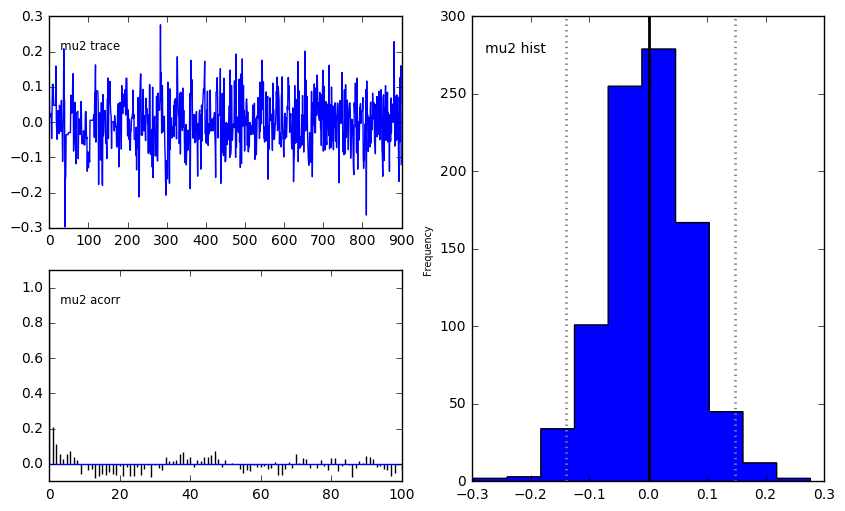

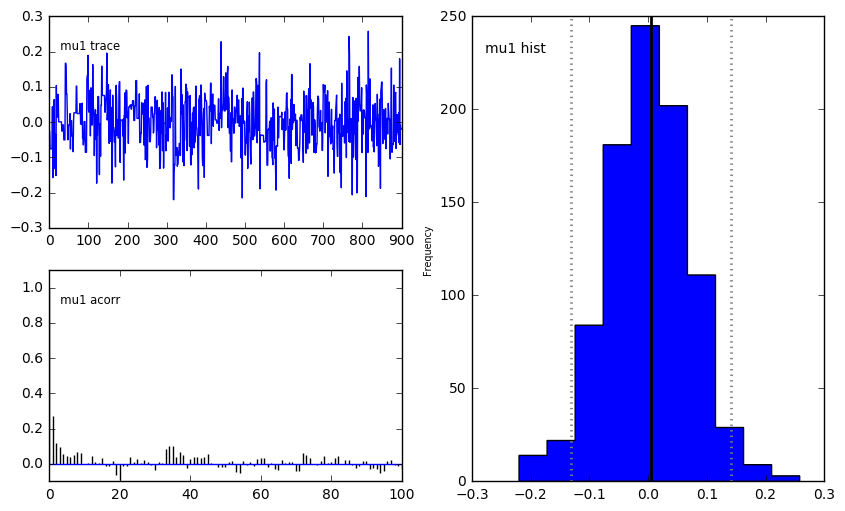

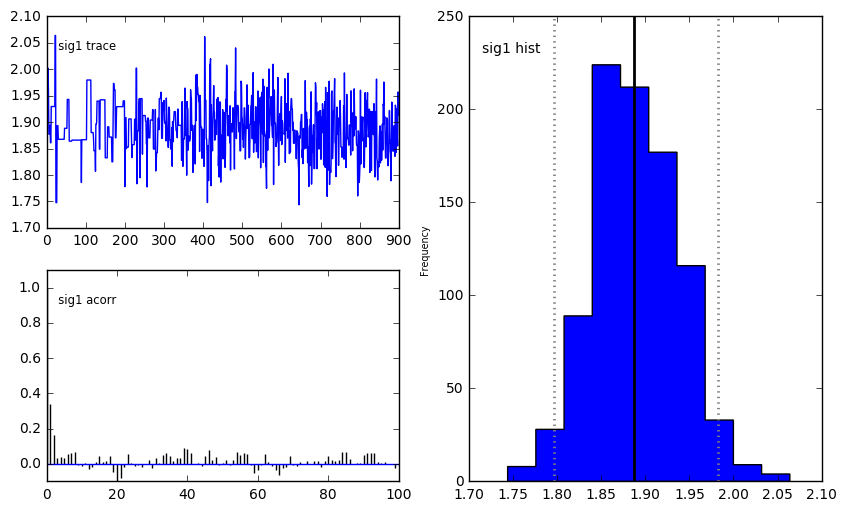

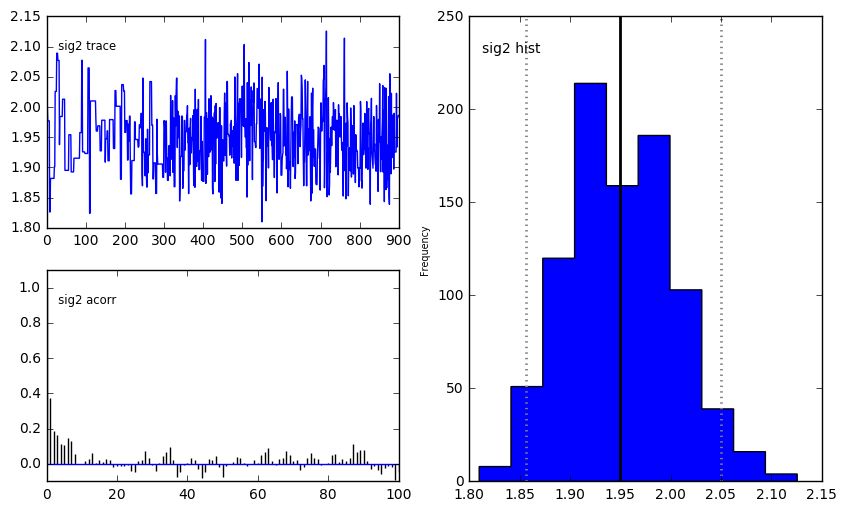

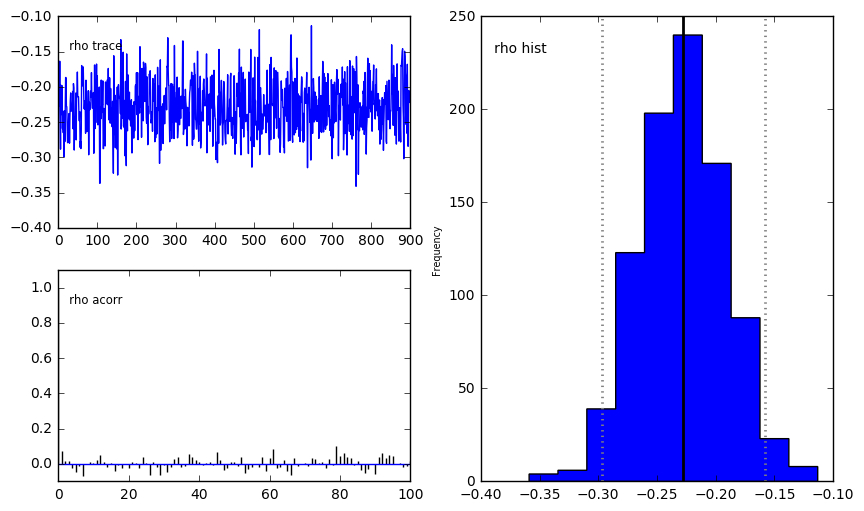

In [25]:
plot(m)

In [26]:
m.summary()


mu2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.0             0.072            0.003            [-0.14   0.148]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.153           -0.048          0.001          0.047         0.137
	

mu1:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.001            0.071            0.003            [-0.132  0.141]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.143           -0.045          0.005          0.047         0.135
	

sig1:
 
	Mean             SD               MC Error        95% HPD interval
	--------------------------

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [27]:
r_oxy=[pearsonr(front_oxy,np.roll(amy_oxy,t))[0] for t in range(-5,6)]
r_pla=[pearsonr(front_pla,np.roll(amy_pla,t))[0] for t in range(-5,6)]

In [28]:
t=np.arange(-5,6)
p_oxy=np.polyfit(t,r_oxy,4)
pd_oxy=np.polyder(p_oxy,1)
roots_oxy=np.roots(pd_oxy)
p_pla=np.polyfit(t,r_pla,4)
pd_pla=np.polyder(p_pla,1)
roots_oxy=np.roots(pd_oxy)
roots_pla=np.roots(pd_pla)
print(roots_pla)
print(roots_oxy)
rfunc_oxy=np.poly1d(p_oxy)
rfit_oxy=rfunc_oxy(t)
rfunc_pla=np.poly1d(p_pla)
rfit_pla=rfunc_pla(t)

[-6.76497922  6.17734644  0.05061596]
[-4.13043931+18.79921841j -4.13043931-18.79921841j  0.82503217 +0.j        ]


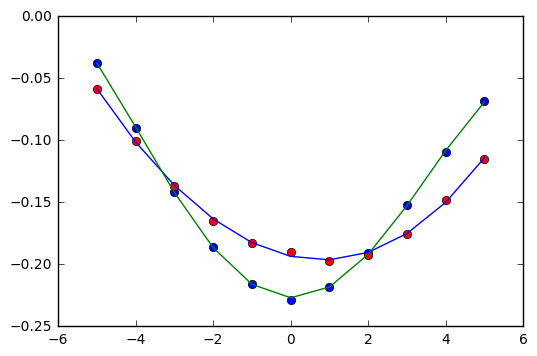

In [29]:
plt.plot(t,r_pla,"ob")
plt.plot(t,r_oxy,"or")
plt.plot(t,rfit_oxy)
plt.plot(t,rfit_pla)